In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from pyarrow import parquet as pq
import dask.dataframe as dd
from google.colab import files
import pandas as pd
import os

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
#!pip install xgboost

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd '/content/drive/MyDrive/MSc Thesis/WhoopData/Shared/Sports_AI - Output files'

/content/drive/MyDrive/MSc Thesis/WhoopData/Shared/Sports_AI - Output files


Injury-related columns:
 - Index 0: 'Did you experience today any type pain or discomfort that did not allow you to play tennis/perform daily activities properly?  If so, please describe the area that caused the injury using one word to answer (you can add more than one word if there is more than one area, i.e: "knee, ankle"). The attached image could serve as a guide to indicate the painful area.'
 - Index 1: 'Have you had any previous tennis-related injuries? If so, please describe the area that caused the injury using one word to answer (you can add more than one word if there is more than one area, i.e: "knee, ankle")'
 - Index 2: 'If you specified any pain or discomfort in the previous question, could you rate on a scale 1-5 the intensity of the pain? 1: almost no feel of pain, 2: you can play tennis normally but you can feel the pain, 3: the pain is affecting your movement, 4: almost no movement allowed due to the pain, 5: cannot move the area due to the pain'
Selected injury col

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:16:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
[[   42   831]
 [   51 15639]]


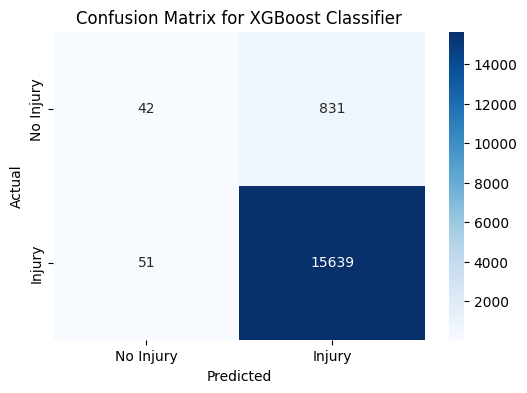


Classification Report:
              precision    recall  f1-score   support

   No Injury       0.45      0.05      0.09       873
      Injury       0.95      1.00      0.97     15690

    accuracy                           0.95     16563
   macro avg       0.70      0.52      0.53     16563
weighted avg       0.92      0.95      0.93     16563

AUC-ROC Score: 0.934


In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Data Preprocessing Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Machine Learning Models
from xgboost import XGBClassifier

# Evaluation Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
file_path = '/content/drive/MyDrive/MSc Thesis/WhoopData/Shared/Sports_AI - Output files/Final_Labeled_Scored_Data.xlsx'  # Replace with your actual file path
df = pd.read_excel(file_path)

# --- Data Preprocessing ---

# Drop columns with all missing values
df.dropna(axis=1, how='all', inplace=True)

# Replace placeholders with NaN
df.replace(['N/A', 'Unknown', '--', '', ' '], np.nan, inplace=True)

# Convert appropriate columns to numeric, coerce errors to NaN
for col in df.columns:
    if df[col].dtype == 'object':
        # Try to convert to numeric; if fails, keep as object
        df[col] = pd.to_numeric(df[col], errors='ignore')

# Identify numeric and non-numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Fill missing values in numeric columns with the mean
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Fill missing values in non-numeric columns with the mode
for col in non_numeric_cols:
    if df[col].isnull().any():
        df[col].fillna(df[col].mode()[0], inplace=True)

# --- Identify Injury-Related Columns ---

# List of keywords to search in column names
injury_keywords = ['pain', 'discomfort', 'injury', 'aches', 'stiffness']

# Find columns containing any of the injury-related keywords
injury_cols = [col for col in df.columns if any(keyword in col.lower() for keyword in injury_keywords)]

print("Injury-related columns:")
for idx, col in enumerate(injury_cols):
    print(f" - Index {idx}: '{col}'")

# Select the injury column using its index
# Replace '0' with the correct index if necessary
injury_column_index = 0  # Change this if the first column is not the correct one
injury_column = injury_cols[injury_column_index]
print(f"Selected injury column: '{injury_column}'")

# Rename the selected injury column for simplicity
df.rename(columns={injury_column: 'Injury_Description'}, inplace=True)
injury_column = 'Injury_Description'
print("Renamed the injury column to 'Injury_Description'")

# Create 'Injury Risk' column
no_injury_values = ['no', 'none', 'n/a', 'na', '', ' ']
df['Injury Risk'] = df[injury_column].apply(
    lambda x: 0 if str(x).strip().lower() in no_injury_values else 1
)
target = 'Injury Risk'
print("Created 'Injury Risk' from the injury-related column.")

# Verify the distribution of 'Injury Risk'
print("Injury Risk distribution:")
print(df['Injury Risk'].value_counts())

# --- Feature Selection ---

# Define your features
features = [
    'Activity Strain',
    'Heart rate variability (ms)',
    'Resting heart rate (bpm)',
    'Asleep duration (min)_x',
    'Sleep efficiency %_x',
    'Sleep performance %_x',
    'Jump - Jump Height (in)_x',
    # Add other relevant features
]

# Ensure features exist in the DataFrame
features = [f for f in features if f in df.columns]
print("Selected features:")
print(features)

# Remove rows with missing target values
df.dropna(subset=[target], inplace=True)

# Split data into features (X) and target (y)
X = df[features]
y = df[target]

# Handle categorical variables (if any)
# For example, one-hot encode 'Activity name' if it's included in features
if 'Activity name' in df.columns and 'Activity name' in features:
    X = pd.get_dummies(X, columns=['Activity name'], drop_first=True)

# --- Train-Test Split ---

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Feature Scaling ---

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- Training the XGBoost Classifier ---

# Initialize the model
xgb_classifier = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the model
xgb_classifier.fit(X_train, y_train)

# --- Making Predictions ---

y_pred = xgb_classifier.predict(X_test)
y_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]

# --- Evaluation Metrics ---

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plotting the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Injury', 'Injury'], yticklabels=['No Injury', 'Injury'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for XGBoost Classifier')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Injury', 'Injury']))

# AUC-ROC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score: {roc_auc:.3f}")


In [ ]:
#file_path = '/content/drive/MyDrive/Sports_AI/Sports_AI - Output files/Final_Labeled_Scored_Data.xlsx'

In [ ]:
import os

# Define the path you want to check
path = '/content/drive/MyDrive/MSc Thesis/WhoopData/Shared/Sports_AI - Output files'  # You can change this to any path you want to check

# List all files and directories in the specified path
files_in_path = os.listdir(path)

# Print the files and directories
print(f"Files and directories in '{path}':")
for file in files_in_path:
    print(file)


Files and directories in '/content/drive/MyDrive/Sports_AI/Sports_AI - Output files/':
Name_Height_weight.xlsx
All_Users_Feature_Engineered_Data.xlsx
Thesis Research - Injury form.xlsx
Men's Tennis Sparta Jumps '23-'24.csv
Women's Tennis Sparta Jumps '24.csv
Final_Merged_Data.xlsx
Final_Labeled_Scored_Data.xlsx


In [ ]:
# Define the file path
file_path = '/content/drive/MyDrive/Sports_AI/Sports_AI - Output files/Final_Labeled_Scored_Data.xlsx'

In [ ]:
# Load the file into a DataFrame
df = pd.read_excel(file_path)
# Display the first 5 rows of the DataFrame
print(df.head(5))

   Activity Strain Activity name  Altitude change (meters)  \
0             14.6        Tennis                       NaN   
1             14.6        Tennis                       NaN   
2             14.6        Tennis                       NaN   
3             14.6        Tennis                       NaN   
4             14.6        Tennis                       NaN   

   Altitude gain (meters)  Answered yes  Asleep duration (min)_x  \
0                     NaN           1.0                      364   
1                     NaN           1.0                      364   
2                     NaN           1.0                      364   
3                     NaN           1.0                      364   
4                     NaN           1.0                      364   

   Asleep duration (min)_y  Average HR (bpm)_x  Average HR (bpm)_y  \
0                    364.0                  76               131.0   
1                    364.0                  76               131.0   
2       

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    roc_auc_score,
    f1_score,
    confusion_matrix
)

# File Path
file_path = '/content/drive/MyDrive/Sports_AI/Sports_AI - Output files/Final_Labeled_Scored_Data.xlsx'

def load_and_prepare_data(file_path):
    """Loads the data, handles potential missing values, and prepares data for regression and classification."""
    df = pd.read_excel(file_path)

    # Handle missing values (replace with appropriate strategy based on data understanding)
    for col in df.columns:
        if df[col].dtype == 'float64' or df[col].dtype == 'int64':
            df[col].fillna(df[col].mean(), inplace=True)

    # Define features and targets
    regression_features = ['Jump - Jump Height (in)_x', 'Activity Strain', 'Altitude gain (meters)']
    regression_target = 'Recovery score %'

    # Ensure the classification target is actually categorical
    classification_features = ['Activity Strain', 'Average HR (bpm)_x']
    classification_target = 'Answered yes'

    # Convert to binary if needed
    if df[classification_target].dtype != 'bool':
        df[classification_target] = df[classification_target].astype(int)  # Assuming 1/0 encoding

    return df, regression_features, regression_target, classification_features, classification_target

def train_and_evaluate_models(df, regression_features, regression_target, classification_features, classification_target):
    """Trains and evaluates the models."""

    # Data Splitting
    X_reg = df[regression_features]
    y_reg = df[regression_target]
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

    X_clf = df[classification_features]
    y_clf = df[classification_target]
    X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

    # Model Training and Evaluation
    models = {
        "Linear Regression": {
            "model": LinearRegression(),
            "features": X_train_reg,
            "target": y_train_reg,
            "type": "regression"
        },
        "XGBoost Regressor": {
            "model": XGBRegressor(),
            "features": X_train_reg,
            "target": y_train_reg,
            "type": "regression"
        },
        "Logistic Regression": {
            "model": LogisticRegression(),
            "features": X_train_clf,
            "target": y_train_clf,
            "type": "classification"
        },
        "XGBoost Classifier": {
            "model": XGBClassifier(),
            "features": X_train_clf,
            "target": y_train_clf,
            "type": "classification"
        }
    }

    for model_name, model_data in models.items():
        print(f"\nTraining and Evaluating {model_name}...")
        model = model_data["model"]
        model.fit(model_data["features"], model_data["target"])

        if model_data["type"] == "regression":
            predictions = model.predict(X_test_reg)
            mae = mean_absolute_error(y_test_reg, predictions)
            rmse = mean_squared_error(y_test_reg, predictions, squared=False)
            r2 = r2_score(y_test_reg, predictions)
            print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R-squared: {r2:.4f}")

        elif model_data["type"] == "classification":
            predictions = model.predict(X_test_clf)
            if hasattr(model, "predict_proba"):
                probabilities = model.predict_proba(X_test_clf)[:, 1]
                auc = roc_auc_score(y_test_clf, probabilities)
                print(f"AUC-ROC: {auc:.4f}")
            accuracy = accuracy_score(y_test_clf, predictions)
            f1 = f1_score(y_test_clf, predictions)
            conf_matrix = confusion_matrix(y_test_clf, predictions)
            print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
            print("Confusion Matrix:")
            print(conf_matrix)

if __name__ == "__main__":
    if os.path.exists(file_path):
        df, reg_features, reg_target, clf_features, clf_target = load_and_prepare_data(file_path)
        train_and_evaluate_models(df, reg_features, reg_target, clf_features, clf_target)
    else:
        print(f"Error: File not found at '{file_path}'")


Training and Evaluating Linear Regression...
MAE: 14.0511, RMSE: 16.8413, R-squared: 0.0090

Training and Evaluating XGBoost Regressor...
MAE: 3.8215, RMSE: 6.8145, R-squared: 0.8378

Training and Evaluating Logistic Regression...
AUC-ROC: 0.5457
Accuracy: 0.8488, F1 Score: 0.0000
Confusion Matrix:
[[14058     0]
 [ 2505     0]]

Training and Evaluating XGBoost Classifier...
AUC-ROC: 0.6947
Accuracy: 0.8515, F1 Score: 0.1003
Confusion Matrix:
[[13967    91]
 [ 2368   137]]



Training and Evaluating Linear Regression...
MAE: 14.0511, RMSE: 16.8413, R-squared: 0.0090


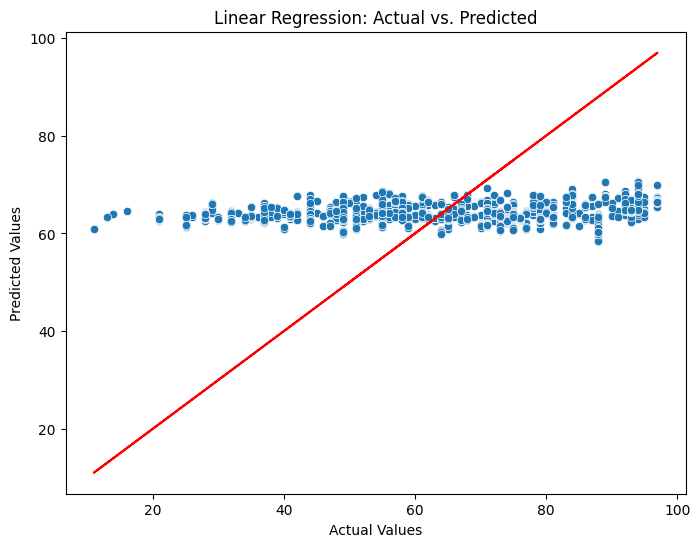


Training and Evaluating XGBoost Regressor...
MAE: 3.8215, RMSE: 6.8145, R-squared: 0.8378

Training and Evaluating Decision Tree Regressor...
MAE: 3.7528, RMSE: 6.8217, R-squared: 0.8374

Training and Evaluating Random Forest Regressor...
MAE: 3.7606, RMSE: 6.8194, R-squared: 0.8375

Training and Evaluating Logistic Regression...
AUC-ROC: 0.5457


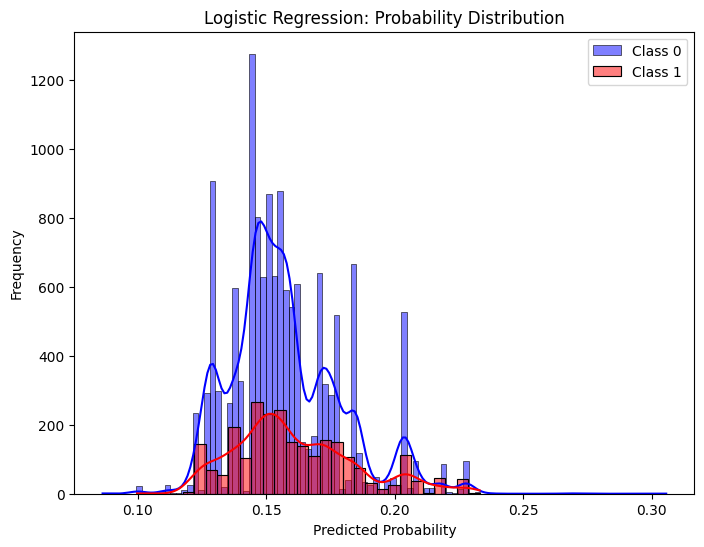

Accuracy: 0.8488, F1 Score: 0.0000
Confusion Matrix:
[[14058     0]
 [ 2505     0]]

Training and Evaluating XGBoost Classifier...
AUC-ROC: 0.6947
Accuracy: 0.8515, F1 Score: 0.1003
Confusion Matrix:
[[13967    91]
 [ 2368   137]]


<Figure size 1000x600 with 0 Axes>

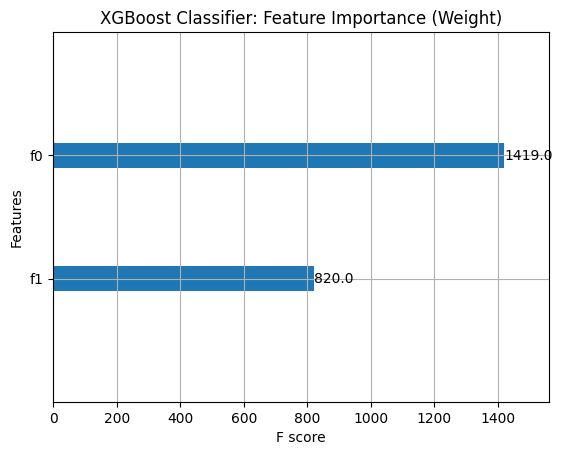

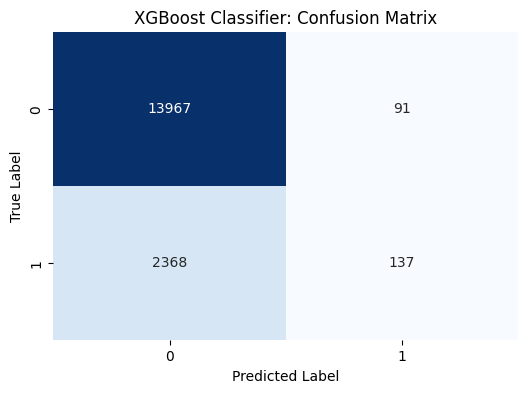


Training and Evaluating Decision Tree Classifier...
AUC-ROC: 0.6944
Accuracy: 0.8514, F1 Score: 0.1176
Confusion Matrix:
[[13938   120]
 [ 2341   164]]


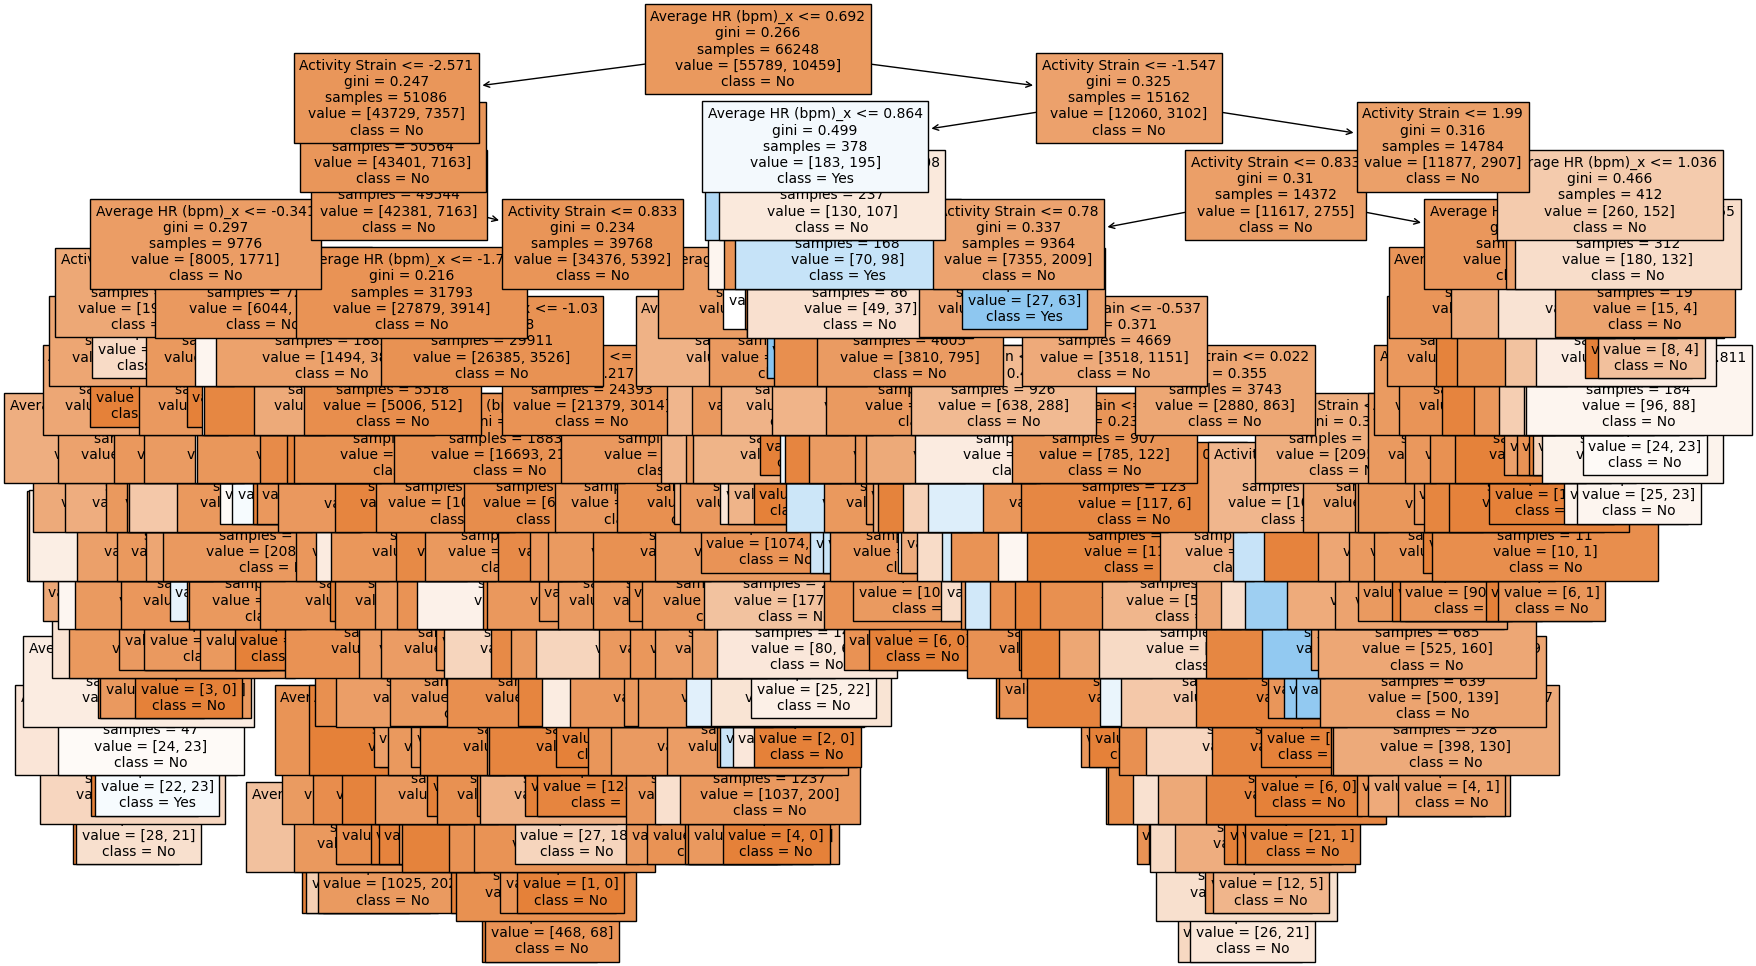


Training and Evaluating Random Forest Classifier...
AUC-ROC: 0.6941
Accuracy: 0.8514, F1 Score: 0.1208
Confusion Matrix:
[[13933   125]
 [ 2336   169]]


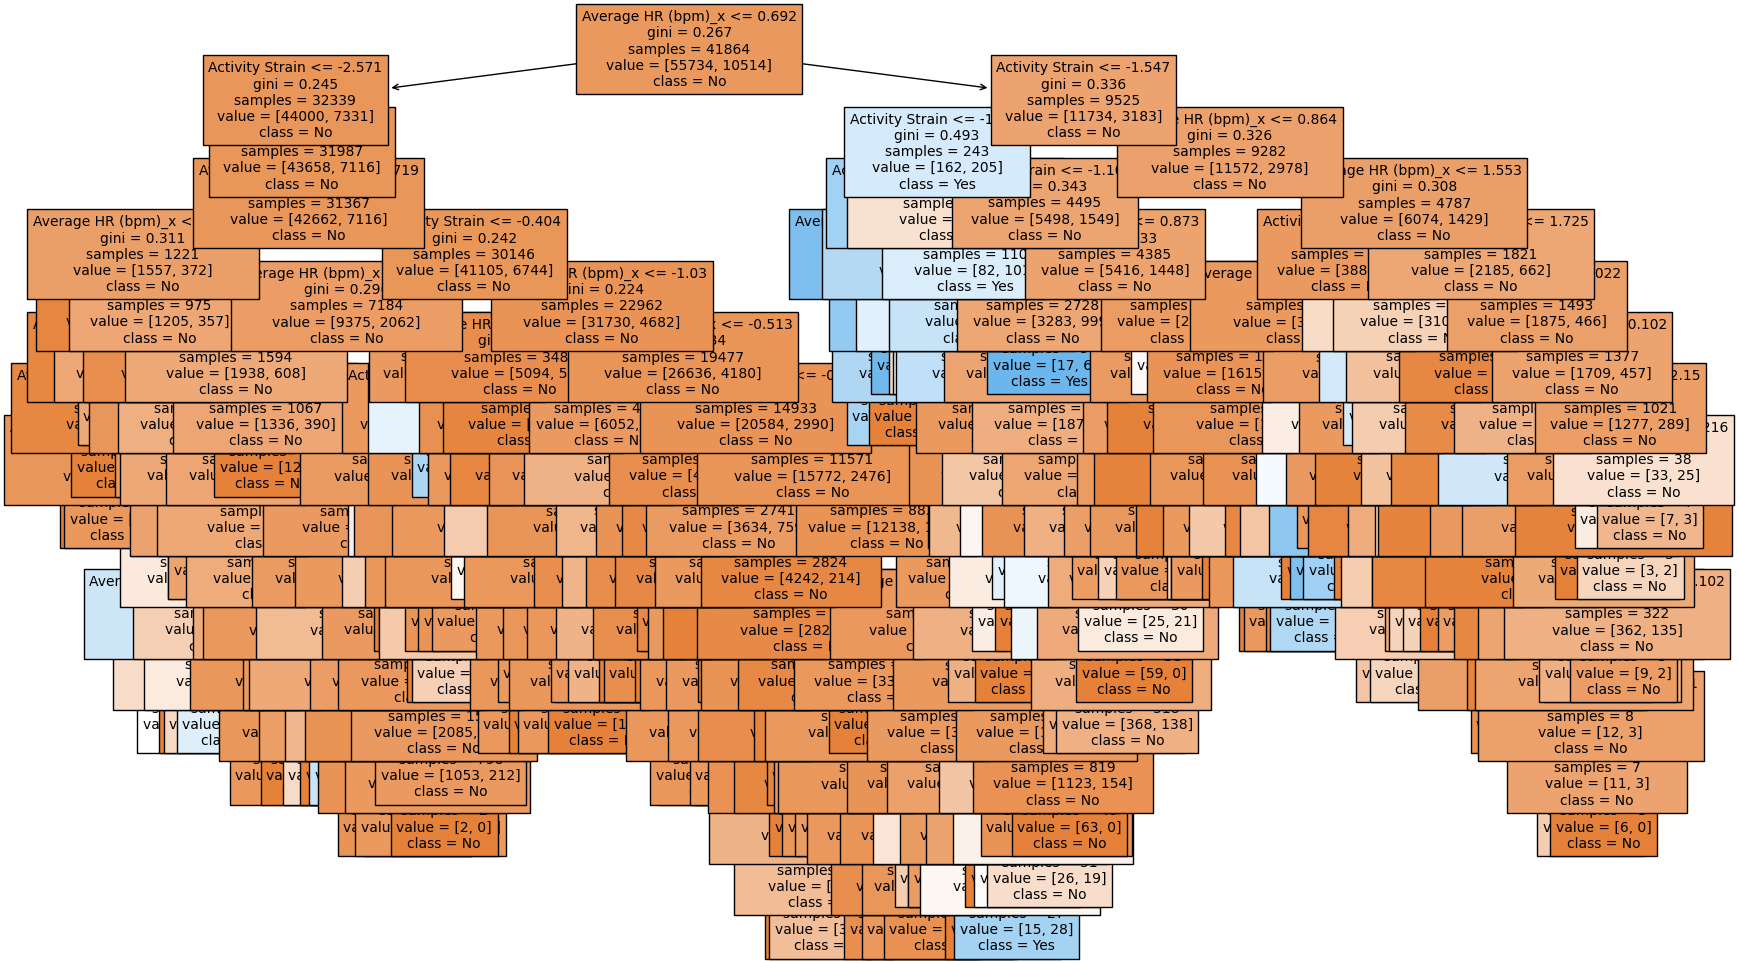

In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from xgboost import XGBRegressor, XGBClassifier, plot_importance
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    roc_auc_score,
    f1_score,
    confusion_matrix,
)
import matplotlib.pyplot as plt
import seaborn as sns

# File Path
file_path = '/content/drive/MyDrive/Sports_AI/Sports_AI - Output files/Final_Labeled_Scored_Data.xlsx'

# --- Data Loading and Preparation ---
def load_and_prepare_data(file_path):
    """Loads the data, handles potential missing values, and prepares data for regression and classification."""
    df = pd.read_excel(file_path)

    # Handle missing values (replace with appropriate strategy based on data understanding)
    for col in df.columns:
        if df[col].dtype == 'float64' or df[col].dtype == 'int64':
            df[col].fillna(df[col].mean(), inplace=True)

    # Define features and targets
    regression_features = ['Jump - Jump Height (in)_x', 'Activity Strain', 'Altitude gain (meters)']
    regression_target = 'Recovery score %'

    classification_features = ['Activity Strain', 'Average HR (bpm)_x']
    classification_target = 'Answered yes'

    # Convert to binary if needed
    if df[classification_target].dtype != 'bool':
        df[classification_target] = df[classification_target].astype(int)

    return df, regression_features, regression_target, classification_features, classification_target

# --- Model Training and Evaluation ---
def train_and_evaluate_models(df, regression_features, regression_target, classification_features, classification_target):
    """Trains and evaluates the models."""

    # Data Splitting (using the same split for all models)
    X_reg = df[regression_features]
    y_reg = df[regression_target]
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
        X_reg, y_reg, test_size=0.2, random_state=42
    )

    X_clf = df[classification_features]
    y_clf = df[classification_target]
    X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
        X_clf, y_clf, test_size=0.2, random_state=42
    )

    # Standardize Features
    scaler_reg = StandardScaler()
    X_train_reg = scaler_reg.fit_transform(X_train_reg)
    X_test_reg = scaler_reg.transform(X_test_reg)

    scaler_clf = StandardScaler()
    X_train_clf = scaler_clf.fit_transform(X_train_clf)
    X_test_clf = scaler_clf.transform(X_test_clf)

    # --- Model Definitions ---
    models = {
        "Linear Regression": {
            "model": LinearRegression(),
            "features": X_train_reg,
            "target": y_train_reg,
            "type": "regression",
            "test_features": X_test_reg,
            "feature_names": regression_features  # Add feature names for Linear Regression
        },
        "XGBoost Regressor": {
            "model": XGBRegressor(),
            "features": X_train_reg,
            "target": y_train_reg,
            "type": "regression",
            "test_features": X_test_reg,
            "feature_names": regression_features
        },
        "Decision Tree Regressor": {
            "model": DecisionTreeRegressor(random_state=42),
            "features": X_train_reg,
            "target": y_train_reg,
            "type": "regression",
            "test_features": X_test_reg,
            "feature_names": regression_features
        },
        "Random Forest Regressor": {
            "model": RandomForestRegressor(random_state=42),
            "features": X_train_reg,
            "target": y_train_reg,
            "type": "regression",
            "test_features": X_test_reg,
            "feature_names": regression_features
        },
        "Logistic Regression": {
            "model": LogisticRegression(),
            "features": X_train_clf,
            "target": y_train_clf,
            "type": "classification",
            "test_features": X_test_clf,
            "feature_names": classification_features
        },
        "XGBoost Classifier": {
            "model": XGBClassifier(),
            "features": X_train_clf,
            "target": y_train_clf,
            "type": "classification",
            "test_features": X_test_clf,
            "feature_names": classification_features
        },
        "Decision Tree Classifier": {
            "model": DecisionTreeClassifier(random_state=42),
            "features": X_train_clf,
            "target": y_train_clf,
            "type": "classification",
            "test_features": X_test_clf,
            "feature_names": classification_features
        },
        "Random Forest Classifier": {
            "model": RandomForestClassifier(random_state=42),
            "features": X_train_clf,
            "target": y_train_clf,
            "type": "classification",
            "test_features": X_test_clf,
            "feature_names": classification_features
        }
    }

    # --- Model Training and Visualization ---
    for model_name, model_data in models.items():
        print(f"\nTraining and Evaluating {model_name}...")
        model = model_data["model"]
        model.fit(model_data["features"], model_data["target"])

        if model_data["type"] == "regression":
            predictions = model.predict(model_data["test_features"])
            mae = mean_absolute_error(y_test_reg, predictions)
            rmse = mean_squared_error(y_test_reg, predictions, squared=False)
            r2 = r2_score(y_test_reg, predictions)
            print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R-squared: {r2:.4f}")

            # Regression Line Plot for Linear Regression
            if model_name == "Linear Regression":
                plt.figure(figsize=(8, 6))
                sns.scatterplot(x=y_test_reg, y=predictions)
                plt.plot(y_test_reg, y_test_reg, color='red')  # Perfect prediction line
                plt.xlabel("Actual Values")
                plt.ylabel("Predicted Values")
                plt.title(f"Linear Regression: Actual vs. Predicted")
                plt.show()

        elif model_data["type"] == "classification":
            predictions = model.predict(model_data["test_features"])
            if hasattr(model, "predict_proba"):
                probabilities = model.predict_proba(model_data["test_features"])[:, 1]
                auc = roc_auc_score(y_test_clf, probabilities)
                print(f"AUC-ROC: {auc:.4f}")

                # Probability Distribution Plot for Logistic Regression
                if model_name == "Logistic Regression":
                    plt.figure(figsize=(8, 6))
                    sns.histplot(probabilities[y_test_clf == 0], color='blue', label='Class 0', kde=True)
                    sns.histplot(probabilities[y_test_clf == 1], color='red', label='Class 1', kde=True)
                    plt.xlabel("Predicted Probability")
                    plt.ylabel("Frequency")
                    plt.title("Logistic Regression: Probability Distribution")
                    plt.legend()
                    plt.show()

            accuracy = accuracy_score(y_test_clf, predictions)
            f1 = f1_score(y_test_clf, predictions)
            conf_matrix = confusion_matrix(y_test_clf, predictions)
            print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
            print("Confusion Matrix:")
            print(conf_matrix)

            # Feature Importance for XGBoost Classifier
            if model_name == "XGBoost Classifier":
                plt.figure(figsize=(10, 6))
                plot_importance(model, importance_type='weight')
                plt.title("XGBoost Classifier: Feature Importance (Weight)")
                plt.show()

                # Confusion Matrix Visualization for XGBoost Classifier
                plt.figure(figsize=(6, 4))
                sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
                plt.xlabel("Predicted Label")
                plt.ylabel("True Label")
                plt.title("XGBoost Classifier: Confusion Matrix")
                plt.show()

            # Tree Visualization for Decision Tree Classifier
            if model_name == "Decision Tree Classifier":
                plt.figure(figsize=(20, 12))
                plot_tree(model, filled=True, feature_names=model_data["feature_names"],
                          class_names=['No', 'Yes'], fontsize=10)
                plt.show()

            # Tree Visualization for Random Forest (Plot only one tree)
            if model_name == "Random Forest Classifier":
                estimator = model.estimators_[0]  # Select the first tree
                plt.figure(figsize=(20, 12))
                plot_tree(estimator, filled=True, feature_names=model_data["feature_names"],
                          class_names=['No', 'Yes'], fontsize=10)
                plt.show()

if __name__ == "__main__":
    if os.path.exists(file_path):
        df, reg_features, reg_target, clf_features, clf_target = load_and_prepare_data(file_path)
        train_and_evaluate_models(df, reg_features, reg_target, clf_features, clf_target)
    else:
        print(f"Error: File not found at '{file_path}'")

In [ ]:
#Last line